 Lambda School Data Science, Unit 2: Predictive Modeling

 # Kaggle Challenge, Module 1

 ## Assignment
 - [ ] Do train/validate/test split with the Tanzania Waterpumps data.
 - [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
 - [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
 - [ ] Get your validation accuracy score.
 - [ ] Get and plot your feature importances.
 - [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
 - [ ] Commit your notebook to your fork of the GitHub repo.


 ## Stretch Goals

 ### Reading

 - A Visual Introduction to Machine Learning
   - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
   - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
 - [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
 - [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
 - [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
 - [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
 - [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


 ### Doing
 - [ ] Add your own stretch goal(s) !
 - [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
 - [ ] Make exploratory visualizations and share on Slack.


 #### Exploratory visualizations

 Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data.

 For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

 ```python
 train['functional'] = (train['status_group']=='functional').astype(int)
 ```



 You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

 - Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
 - Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

 You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

 You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

 #### High-cardinality categoricals

 This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

 ```python
 # Reduce cardinality for NEIGHBORHOOD feature ...

 # Get a list of the top 10 neighborhoods
 top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

 # At locations where the neighborhood is NOT in the top 10,
 # replace the neighborhood with 'OTHER'
 train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
 test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
 ```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    get_ipython().system('pip install category_encoders==2.*')

# If you're working locally:
else:
    DATA_PATH = './data/'



In [2]:
import pandas
from sklearn.model_selection import train_test_split

train = pandas.merge(pandas.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pandas.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test_features = pandas.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pandas.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test_features.shape


((59400, 41), (14358, 40))

In [3]:
from typing import Optional

def keepTopN(	column:pandas.Series,
				n:int,
				default:Optional[object] = None) -> pandas.Series:
	"""
	Keeps the top n most popular values of a Series, while replacing the rest with `default`
	
	Args:
		column (pandas.Series): Series to operate on
		n (int): How many values to keep
		default (object, optional): Defaults to NaN. Value with which to replace remaining values
	
	Returns:
		pandas.Series: Series with the most popular n values
	"""
	import numpy

	if default is None: default = numpy.nan

	val_counts = column.value_counts()
	if n > len(val_counts): n = len(val_counts)
	top_n = list(val_counts[:n].index)
	return(column.where(column.isin(top_n), other=default))

def oneHot(	frame:pandas.DataFrame, 
			cols:Optional[list] = None,
			exclude_cols:Optional[list] = None,
			max_cardinality:Optional[int] = None) -> pandas.DataFrame:
	"""
	One-hot encodes the dataframe.
	
	Args:
		frame (pandas.DataFrame): Dataframe to clean
		cols (list, optional): Columns to one-hot encode. Defaults to all string columns.
		exclude_cols (list, optional): Columns to skip one-hot encoding. Defaults to None.
		max_cardinality (int, optional): Maximum cardinality of columns to encode. Defaults to no maximum cardinality.
	
	Returns:
		pandas.DataFrame: The one_hot_encoded dataframe.
	"""
	import category_encoders

	one_hot_encoded = frame.copy()

	if cols is None: cols = list(one_hot_encoded.columns[one_hot_encoded.dtypes=='object'])

	if exclude_cols is not None:
		for col in exclude_cols:
			cols.remove(col)

	if max_cardinality is not None:
		described = one_hot_encoded[cols].describe(exclude=[numpy.number])
		cols = list(described.columns[described.loc['unique'] <= max_cardinality])

	encoder = category_encoders.OneHotEncoder(return_df=True, use_cat_names=True, cols=cols)
	one_hot_encoded = encoder.fit_transform(one_hot_encoded)

	return(one_hot_encoded)


In [4]:
def clean_X(df, max_ordinality=100, int_ts=False, n_clusters=100):

	cleaned = df.copy().drop(columns=['recorded_by'])


	from sklearn.cluster import KMeans

	kmeans=KMeans(n_clusters=n_clusters)
	kmeans.fit(cleaned[['latitude', 'longitude']])
	cleaned['cluster'] = kmeans.labels_


	categorical_description = cleaned.describe(exclude=[numpy.number])
	if int_ts: 
		cat_cols = categorical_description.drop(columns=['date_recorded']).columns
	else:
		cat_cols = categorical_description.columns
	# high_ordinality_cols = categorical_description[categorical_description.loc['unique'] > max_ordinality].columns
	
	for col in cat_cols:
		cleaned[col] = keepTopN(cleaned[col], max_ordinality, default='other')

	if int_ts:
		cleaned['date_recorded_dt'] = pandas.to_datetime(df['date_recorded'])
		cleaned['date_recorded_ts'] = cleaned['date_recorded_dt'].view('int64')

		return(cleaned.drop(columns=['date_recorded_dt', 'date_recorded']))
	else:
		return(cleaned)



In [5]:
train_targets = train.sort_values(by=['id'])['status_group'].replace({'functional': 1, 'functional needs repair': 2, 'non functional': 3})
train_features = train.sort_values(by=['id']).drop(columns=['status_group'])


In [6]:
import numpy
combined = pandas.concat([train_features, test_features])
cleaned_combined = oneHot(clean_X(combined, max_ordinality=100, int_ts=True))
cleaned_train = cleaned_combined[cleaned_combined['id'].isin(train_features['id'])].sort_values(by=['id'])
cleaned_test = cleaned_combined[cleaned_combined['id'].isin(test_features['id'])].sort_values(by=['id'])


In [8]:
X_train, X_val, y_train, y_val = train_test_split(cleaned_train, train_targets, random_state=33)



In [9]:
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as preprocessing
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection as model_selection



In [10]:
train_scores = []
test_scores = []

min_samples_range = list(range(2500,250,-50)) + list(range(250,50,-10)) + list(range(50,1,-1))

for i in min_samples_range:
	print(i)
	dtc = DecisionTreeClassifier(	min_samples_leaf=i,
									criterion='entropy',
									random_state=i)
	pipeline = Pipeline([('DecisionTreeClassifier', dtc)])

	pipeline.fit(X_train, y_train)

	train_scores.append(pipeline.score(X_train, y_train))
	test_scores.append(pipeline.score(X_val, y_val))


2500
2450
2400
2350
2300
2250
2200
2150
2100
2050
2000
1950
1900
1850
1800
1750
1700
1650
1600
1550
1500
1450
1400
1350
1300
1250
1200
1150
1100
1050
1000
950
900
850
800
750
700
650
600
550
500
450
400
350
300
250
240
230
220
210
200
190
180
170
160
150
140
130
120
110
100
90
80
70
60
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2


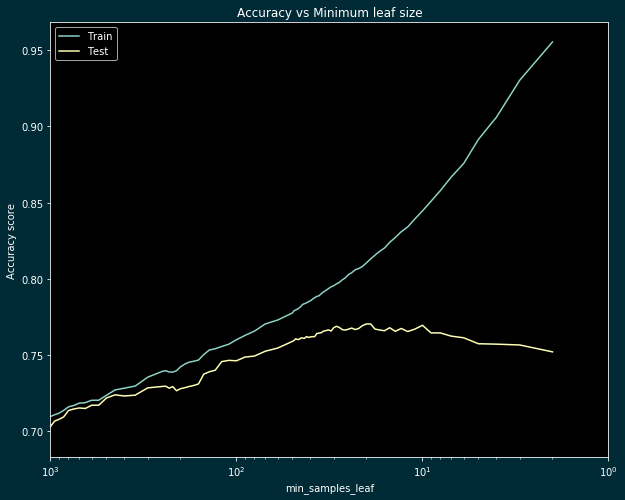

In [11]:
import matplotlib.pyplot as pyplot
pyplot.rcParams['figure.facecolor'] = '#002B36'
pyplot.rcParams['axes.facecolor'] = 'black'
pyplot.rcParams['figure.figsize'] = (10,8)

pyplot.plot(min_samples_range, train_scores, label='Train')
pyplot.plot(min_samples_range, test_scores, label='Test')
pyplot.xscale('log')
pyplot.xlim(left=1000, right=1)
# pyplot.gcf().axes[0].set_xticks(range(1000,-50, -5))
pyplot.title('Accuracy vs Minimum leaf size')
pyplot.xlabel('min_samples_leaf')
pyplot.ylabel('Accuracy score')
pyplot.legend()
pyplot.show()


In [12]:
max(test_scores)


0.7703703703703704

In [13]:

dtc = DecisionTreeClassifier(	min_samples_leaf=10,
								criterion='entropy',
								random_state=33)
pipeline = Pipeline([('DecisionTreeClassifier', dtc)])
pipeline.fit(X_train, y_train)
pipeline.score(X_val, y_val)


0.7687542087542087

In [14]:

y_pred = pipeline.predict(cleaned_test)
out_df = pandas.DataFrame(y_pred, index=cleaned_test['id'], columns=['status_group'])
out_df['status_group'] = out_df['status_group'].replace({1: 'functional', 2: 'functional needs repair', 3: 'non functional'})


In [15]:
out_df = out_df.reset_index()


In [16]:
out_df


,id,status_group
0,10,functional
1,13,non functional
2,14,functional
3,29,non functional
4,32,functional
...,...,...
14353,74241,functional needs repair
14354,74244,non functional
14355,74245,functional
14356,74248,non functional


In [17]:
out_df.to_csv('./module1/results.csv', index=False)

